In [1]:
import numpy as np
from sklearn.preprocessing import scale, robust_scale, minmax_scale
from scipy import stats
import scipy.stats
import pandas as pd
import statsmodels.api as sm #그래프 출력시
import matplotlib as mpl #그래프 옵션
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import graphviz
import os
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.formula.api import ols
from statsmodels.tools.eval_measures import rmse
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import scale
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from datetime import datetime
from sklearn import metrics

import matplotlib.pyplot as plt #그래프 출력시
import matplotlib as mpl #그래프 옵션

#그래프의 한글을 더욱 선명하게 출력
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

#그래프의 음수값이 나올때, 깨지는 현상 방지
mpl.rc('axes', unicode_minus=False)

#그래프 시각화 옵션
%matplotlib inline
#그래프 한글 설정
mpl.rc('font',family="NanumGothic")
plt.rcParams['axes.unicode_minus']=False

#글씨를 선명하게
set_matplotlib_formats

#음수처리
mpl.rc('axes', unicode_minus=False)

In [2]:
ds_tr = pd.read_excel('/home/pirl/Desktop/data.xlsx',sheetname='app_transaction')
ds_tr.info()
ds_us = pd.read_excel('/home/pirl/Desktop/data.xlsx',sheetname='app_user')
ds_us.info()

#csv로 읽을 시 엔진=파이썬 제거해야 칼럼 1로 안 읽음
#tr은 결측치 없이 모든 열이 10000개의 관측치 존재
#us는 결측치가 있는 열이 많음

/home/pirl/anaconda3/lib/python3.7/site-packages/pandas/io/excel.py:329: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  **kwds)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
회원코드          10000 non-null object
프로그램          10000 non-null object
상태            10000 non-null object
프로그램가격        10000 non-null int64
최종결제금액        10000 non-null int64
결제시각          10000 non-null object
결제유형          10000 non-null object
채널            10000 non-null object
보조식품가격        10000 non-null int64
보조식품(추가구매)    10000 non-null object
기기종류          10000 non-null object
기기제조사         10000 non-null object
OSversion     10000 non-null object
dtypes: int64(3), object(10)
memory usage: 1015.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
회원코드              10000 non-null object
성별                9869 non-null float64
연령                9869 non-null float64
신장                9869 non-null float64
회원초기체중            9869 non-null float64
최저체중              5777 non-null float64
목표체중              9869 no

In [3]:
ds=pd.merge(ds_tr, ds_us, on='회원코드', how='outer') #회원코드 기준 통합
ds.info() #22개 변수(결제유형 삭제), 10000개의 관측치

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 23 columns):
회원코드              10000 non-null object
프로그램              10000 non-null object
상태                10000 non-null object
프로그램가격            10000 non-null int64
최종결제금액            10000 non-null int64
결제시각              10000 non-null object
결제유형              10000 non-null object
채널                10000 non-null object
보조식품가격            10000 non-null int64
보조식품(추가구매)        10000 non-null object
기기종류              10000 non-null object
기기제조사             10000 non-null object
OSversion         10000 non-null object
성별                9869 non-null float64
연령                9869 non-null float64
신장                9869 non-null float64
회원초기체중            9869 non-null float64
최저체중              5777 non-null float64
목표체중              9869 non-null float64
당뇨여부(설문)          9994 non-null object
음주여부(설문)          10000 non-null object
일주일운동횟수(설문)       10000 non-null object
건강보조식품복용여부(설문)  

In [5]:
ds = ds[~ds['연령'].isnull()]

In [6]:
#raw 결제시각의 date를 추출하는 함수
def timetodate(row):
    return row[:11]

#raw 결제시각의 오전, 오후를 시각으로 바꾸는 함수
def timetosplit(row):
    if(row[11:13]=='오전'):
        
        if(row[-15:-13]=='12'):
            
            return row[:10]+' 0'+row[-13:]
        
        return row[:10]+' '+row[-15:]
    
    if(row[-15:-13]=='12'):
        
            return row[:10]+' '+row[-15:]
        
    return row[:10]+' '+str(int(row[-15:-13])+12)+':'+row[-12:]

#결제시각_new에서 결제시를 가져오는 함수
def timetoclock(row):
    return row[-15:-13]

#raw 결제시각의 ms를 가져오는 함수
def timetoms(row):
    return row[-6:]

#나이대를 가져오는 함수(많은 비율을 차지하는 20대는 초반과 후반 구분)
def ages_10(row):
    if row>=20 and row<25 :
        return '20대 초반'
    if row>=25 and row<30 :
        return '20대 후반'
#     if row>=50:
#         return '50대 이상'
    return str(int(row/10)*10)+'대'

In [7]:
ds['감량치']=ds['회원초기체중']-ds['최저체중']
ds['BMI']=ds['회원초기체중']/((ds['신장']/100)**2)
ds['date']=ds['결제시각'].apply(timetodate)
ds['결제시각_new']=ds['결제시각'].apply(timetosplit)
ds['결제시']=ds['결제시각_new'].apply(timetoclock)

#date, BMI, 결제시각_new data 생성
print(ds['date'].head())
print(ds['BMI'].head())
print(ds[['결제시각_new','결제시각']].head(100))
print(ds['결제시'].head(20))

/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

0    2017-04-14 
1    2017-05-23 
2    2017-08-23 
3    2017-08-28 
4    2017-05-07 
Name: date, dtype: object
0    22.613575
1    22.598140
2    33.514586
3    27.617187
4    20.385675
Name: BMI, dtype: float64
                       결제시각_new                           결제시각
0    2017-04-14 19:03:29.976000   2017-04-14 오후 7:03:29.976000
1    2017-05-23 20:53:54.368000   2017-05-23 오후 8:53:54.368000
2    2017-08-23 23:39:21.840000  2017-08-23 오후 11:39:21.840000
3    2017-08-28 20:18:22.824000   2017-08-28 오후 8:18:22.824000
4    2017-05-07 17:50:30.944000   2017-05-07 오후 5:50:30.944000
5    2017-08-24  8:24:43.256000   2017-08-24 오전 8:24:43.256000
6    2017-05-25  9:38:14.776000   2017-05-25 오전 9:38:14.776000
7    2017-04-17 19:19:01.024000   2017-04-17 오후 7:19:01.024000
8    2017-08-09 15:24:28.296000   2017-08-09 오후 3:24:28.296000
9    2017-08-03 21:03:44.352000   2017-08-03 오후 9:03:44.352000
10   2017-07-30  9:49:03.624000   2017-07-30 오전 9:49:03.624000
11   2017-06-13  9:40:59.264000 

/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [8]:
ds['date']=pd.to_datetime(ds['date'])
ds['결제월']=ds['date'].dt.month
ds['결제요일']=ds['date'].dt.weekday_name
ds['결제일']=ds['date'].dt.day
ds['ms']=ds['결제시각'].apply(timetoms)
ds['나이대']=ds['연령'].apply(ages_10)

print(ds['결제월'].head())
print(ds['결제요일'].head())
print(ds['결제일'].head())
print(ds['ms'].head())
print(ds[['나이대','연령']].head(10))

/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

0    4
1    5
2    8
3    8
4    5
Name: 결제월, dtype: int64
0       Friday
1      Tuesday
2    Wednesday
3       Monday
4       Sunday
Name: 결제요일, dtype: object
0    14
1    23
2    23
3    28
4     7
Name: 결제일, dtype: int64
0    976000
1    368000
2    840000
3    824000
4    944000
Name: ms, dtype: object
      나이대    연령
0  20대 후반  25.0
1  20대 후반  26.0
2  20대 초반  23.0
3  20대 초반  20.0
4  20대 후반  28.0
5  20대 후반  26.0
6     40대  41.0
7  20대 초반  23.0
8  20대 초반  22.0
9  20대 후반  28.0


/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [9]:
def div_bmi(row):
    if row >=40 :
        return '고도비만'
    if (row >= 30) & (row < 40):
        return '비만'
    if (25 <= row) & (row < 30):
        return '과체중'
    if (20 <= row ) & (row < 25):
        return '정상'
    if (row < 20) :
        return '저체중'
    else :
        return np.nan    
ds['비만도']= ds['BMI'].apply(div_bmi)
ds['비만도'].value_counts()
#정상 : BMI 20~25, 
#과체중(1도 비만) : BMI 25~29.9, 
#비만(2도 비만) : BMI 30~40, 
#고도비만 : BMI 40.1 이상을 말한다.

/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


정상      5168
과체중     2779
비만      1249
저체중      606
고도비만      67
Name: 비만도, dtype: int64

In [162]:
ds_new=ds[ds['목표체중']-ds['회원초기체중']<0]

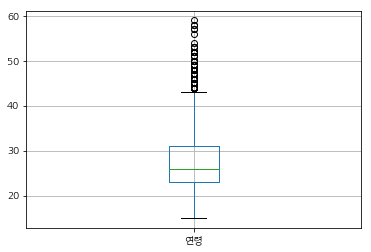

In [163]:
ds_new=ds_new[ds_new['연령']<60]
ds_new=ds_new[ds_new['연령']>0] #연령 60이상, 0 이하를 이상치로 보고 제거
ds_new.boxplot(column="연령")

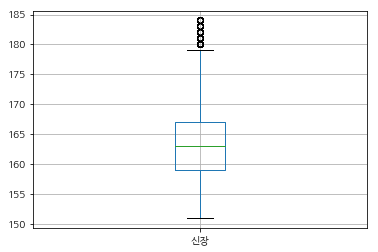

In [164]:
ds_new=ds_new[ds_new['신장']>150]#신장이 150 이하를 이상치로 보고 제거
ds_new=ds_new[ds_new['신장']<185]#신장이 185 이상을 이상치로 보고 제거
ds_new.boxplot(column="신장")

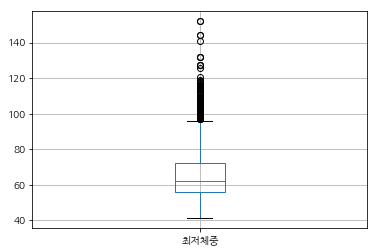

In [165]:
ds_new.loc[ds_new['최저체중']<35, '최저체중']=np.nan #최저체중이 35미만을 결측치로 처리! (이미 결측치가 많음)
ds_new.boxplot(column='최저체중')

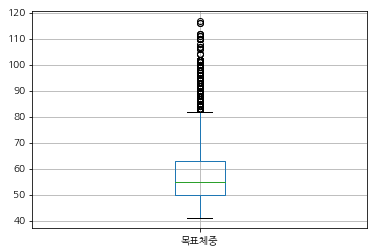

In [200]:
ds_new=ds_new[ds_new['목표체중']>40] #목표체중이 40미만을 이상치로 보고 제거
ds_new.boxplot(column='목표체중')

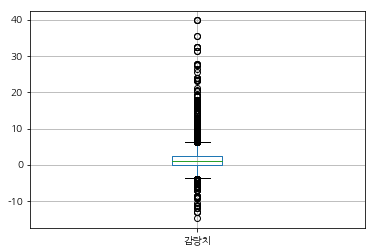

In [167]:
ds_new.loc[ds_new['감량치']>=40, '감량치']=np.nan #감량치 40이상을 이상치로 보고 결측치로 처리! (이미 결측치가 많음)
ds_new.loc[ds_new['감량치']<=-15, '감량치']=np.nan
ds_new.boxplot(column='감량치')

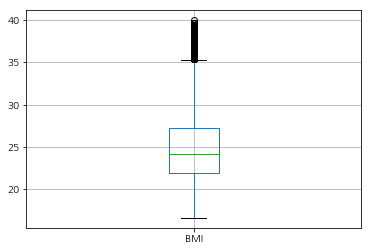

In [168]:
ds_new=ds_new[ds_new['BMI']<40] #BMI 40이상을 이상치로 보고 제거
ds_new.boxplot(column="BMI")

In [ ]:
ds['zam']=ds[ds['결제시']>6]

In [169]:
ds_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9542 entries, 0 to 9999
Data columns (total 35 columns):
회원코드              9542 non-null object
프로그램              9542 non-null object
상태                9542 non-null object
프로그램가격            9542 non-null int64
최종결제금액            9542 non-null int64
결제시각              9542 non-null object
결제유형              9542 non-null object
채널                9542 non-null object
보조식품가격            9542 non-null int64
보조식품(추가구매)        9542 non-null object
기기종류              9542 non-null object
기기제조사             9542 non-null object
OSversion         9542 non-null object
성별                9542 non-null float64
연령                9542 non-null float64
신장                9542 non-null float64
회원초기체중            9542 non-null float64
최저체중              5565 non-null float64
목표체중              9542 non-null float64
당뇨여부(설문)          9542 non-null object
음주여부(설문)          9542 non-null object
일주일운동횟수(설문)       9542 non-null object
건강보조식품복용여부(설문)    9542 non-null 

In [170]:
ds_new.columns

Index(['회원코드', '프로그램', '상태', '프로그램가격', '최종결제금액', '결제시각', '결제유형', '채널',
       '보조식품가격', '보조식품(추가구매)', '기기종류', '기기제조사', 'OSversion', '성별', '연령', '신장',
       '회원초기체중', '최저체중', '목표체중', '당뇨여부(설문)', '음주여부(설문)', '일주일운동횟수(설문)',
       '건강보조식품복용여부(설문)', '감량치', 'BMI', 'date', '결제시각_new', '결제시', '결제월',
       '결제요일', '결제일', 'ms', '나이대', '비만도', '결제'],
      dtype='object')

In [171]:
# def remove_outlier_std(df):
#     for i in range(0, len(df.iloc[1])):
#         df = df[(np.abs(df.iloc[:,i] - df.iloc[:,i].mean()) < (3*df.iloc[:,i].std()))]
#     return df
# #3sigma를 벗어나는 data제거 함수

# ds_new=remove_outlier_std(ds)
# ds_new.info()

In [172]:
import os
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore') #경고 무시

In [349]:
ds_new['결제']=ds_new['상태'].replace('completed',1).replace('refunded',1).replace('cancelled',0)
ds1 = ds_new[['결제','연령','신장','목표체중','성별','채널','결제요일','결제시','프로그램가격', '음주여부(설문)', '일주일운동횟수(설문)',
       '건강보조식품복용여부(설문)']]
ds2 = pd.get_dummies(ds1)

In [350]:
sc_y=ds2["결제"]
sc_x=ds2.drop("결제",axis=1, inplace=False)

sc_train_x, sc_test_x, sc_train_y, sc_test_y = train_test_split(sc_x,sc_y, test_size=0.3, random_state=1234)
print("train data X size: {}".format(sc_train_x.shape))
print("train data Y size: {}".format(sc_train_y.shape))
print("test data X size: {}".format(sc_test_x.shape))
print("test data Y size: {}".format(sc_test_y.shape))

train data X size: (6650, 55)
train data Y size: (6650,)
test data X size: (2851, 55)
test data Y size: (2851,)


In [351]:
tree_uncustomized = DecisionTreeClassifier(random_state=314)
tree_uncustomized.fit(sc_train_x,sc_train_y)
#훈련데이터 정확도
print("Accuracry on training set: {:.3f}".format(tree_uncustomized.score(sc_train_x,
                                                                        sc_train_y)))
#test 데이터 정확도
print("Accuracry on test set: {:.3f}".format(tree_uncustomized.score(sc_test_x,
                                                                       sc_test_y)))
#tree모형 생성

Accuracry on training set: 0.954
Accuracry on test set: 0.586


In [352]:
parameters = {  
              'criterion': ["gini", "entropy"],
              'max_depth': list(i for i in range(2,10)), 
              'min_samples_leaf': list(i for i in range(10,50,4))
             }

grid_obj = GridSearchCV(tree_uncustomized, parameters)
grid_obj

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=314,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [2, 3, 4, 5, 6, 7, 8, 9], 'min_samples_leaf': [10, 14, 18, 22, 26, 30, 34, 38, 42, 46]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [353]:
grid_obj = grid_obj.fit(sc_train_x, sc_train_y)
searchcv = grid_obj.best_estimator_
searchcv.fit(sc_train_x, sc_train_y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=14, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=314,
            splitter='best')

In [354]:
predictions = searchcv.predict(sc_test_x)
print("Accuracy on test set:", accuracy_score(sc_test_y, predictions).round(3))

Accuracy on test set: 0.594


In [355]:
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
ds_feature_importance = pd.DataFrame()
ds_feature_importance["Feature"] = sc_train_x.columns
ds_feature_importance["Importance"] = searchcv.feature_importances_
# ds_feature_importance의 테이블을 중요도별로 정렬
ds_feature_importance.sort_values("Importance", ascending=False).head(9)

,Feature,Importance
0,연령,0.656699
2,목표체중,0.131193
1,신장,0.085568
32,결제시_13,0.079365
12,결제요일_Friday,0.047175
41,결제시_22,0.000000
31,결제시_12,0.000000
33,결제시_14,0.000000
34,결제시_15,0.000000


Accuracy: 0.583


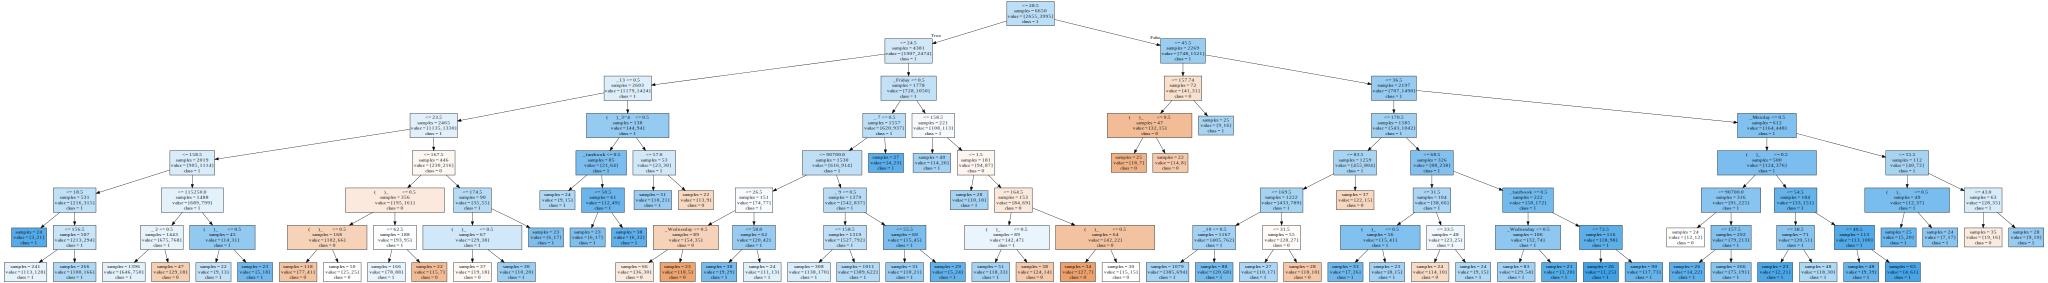

In [356]:
#트리모델 생성,criterion="gini",max_depth=2, min_samples_leaf=10으로 모델 생성
tree1 = DecisionTreeClassifier(criterion="entropy",max_depth=7,random_state=1234,
                         min_samples_leaf=22)
#tree model training
tree1.fit(sc_train_x,sc_train_y)
print("Accuracy: {0:.3f}".format(tree1.score(sc_test_x,sc_test_y)))
#트리모델을 tree.dot파일로 저장
export_graphviz(tree1,out_file="tree.dot", class_names=["0","1"],
              feature_names=sc_train_x.columns,impurity=False,filled=True)
#path 설정:graphviz를 설치 했다면, 설치 된 경로를 설정. 기본 경로는 아래 예제 참고
os.environ["PATH"] += os.pathsep +""

#graphviz를 이용해 트리 모델 시각화
with open("tree.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

In [357]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score

In [359]:
rf_uncustomized = RandomForestClassifier(random_state=1234)
rf_uncustomized.fit(sc_train_x, sc_train_y)
# 훈련 데이터 정확도
print("Accucary on training set: {:.3f}".format(rf_uncustomized.score(sc_train_x, sc_train_y)))
# test 데이터 정확도
print("Accucary on test set: {:.3f}".format(rf_uncustomized.score(sc_test_x, sc_test_y)))
# randomforest 모형 생성

Accucary on training set: 0.945
Accucary on test set: 0.570


In [360]:
rf_uncustomized = RandomForestClassifier(random_state=123)
rf_uncustomized.fit(sc_train_x, sc_train_y)
# 훈련 데이터 정확도
print("Accucary on training set: {:.3f}".format(rf_uncustomized.score(sc_train_x, sc_train_y)))
# test 데이터 정확도
print("Accucary on test set: {:.3f}".format(rf_uncustomized.score(sc_test_x, sc_test_y)))
# randomforest 모형 생성

Accucary on training set: 0.945
Accucary on test set: 0.559


In [361]:
grid_obj= grid_obj.fit(sc_train_x, sc_train_y)
searchcv = grid_obj.best_estimator_
searchcv.fit(sc_train_x, sc_train_y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=14, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=314,
            splitter='best')

In [362]:
predictions = searchcv.predict(sc_test_x)
print("Accuracy on test set:", accuracy_score(sc_test_y, predictions).round(3))

Accuracy on test set: 0.594


In [363]:
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
ds_feature_importance = pd.DataFrame()
ds_feature_importance["Feature"] = sc_train_x.columns
ds_feature_importance["Importance"] = searchcv.feature_importances_
# ds_feature_importance의 테이블을 중요도별로 정렬
ds_feature_importance.sort_values("Importance", ascending=False).head(9)

,Feature,Importance
0,연령,0.656699
2,목표체중,0.131193
1,신장,0.085568
32,결제시_13,0.079365
12,결제요일_Friday,0.047175
41,결제시_22,0.000000
31,결제시_12,0.000000
33,결제시_14,0.000000
34,결제시_15,0.000000


In [ ]:

rf_model = RandomForestClassifier(criterion = "entropy", max_depth= 3, min_samples_leaf = 5, \
                                  n_estimators = 1, random_state= 1234)
rf_model.fit(sc_train_x, sc_train_y)

feature_importance = pd.DataFrame()
feature_importance["feature"] = sc_train_x.columns
feature_importance["importance"] = rf_model.feature_importances_
feature_importance.sort_values( by = "importance" , ascending = False)

# 설명변수 중요도 그래프 함수 정의
def plot_feature_importance(model):
    n_features = sc_train_x.shape[1]
    plt.barh(range(n_features), model.feature_importances_ , align= "center")
    plt.yticks(np.arange(n_features), sc_train_x.columns)
    plt.xlabel("importance of explanatory variable")
    plt.ylabel("explanatory variable")
    plt.ylim(-1, n_features)
    
plot_feature_importance(rf_model)